In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import graspologic

In [2]:
# reading data
df_features = pd.read_csv("./elliptic/elliptic_txs_features.csv", header=None)
df_classes= pd.read_csv("./elliptic/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./elliptic/elliptic_txs_edgelist.csv")

# renaming columns
df_classes.loc[df_classes['class'] == '1', 'class'] = "illicit"
df_classes.loc[df_classes['class'] == '2', 'class'] = "licit"

df_features.columns = ["id", "time step"] + [f"local_feat_{i}" for i in range(93)] + [f"agg_feat_{i}" for i in range(72)]
df_classes.columns = ["id", "class"]

# adding class data
df = pd.merge(df_features, df_classes, how="inner", on="id")
second_column = df.pop('class')
df.insert(1, 'class', second_column)
df.head()

,id,class,time step,local_feat_0,local_feat_1,local_feat_2,local_feat_3,local_feat_4,local_feat_5,local_feat_6,...,agg_feat_62,agg_feat_63,agg_feat_64,agg_feat_65,agg_feat_66,agg_feat_67,agg_feat_68,agg_feat_69,agg_feat_70,agg_feat_71
0,230425980,unknown,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,unknown,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,unknown,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,licit,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,unknown,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


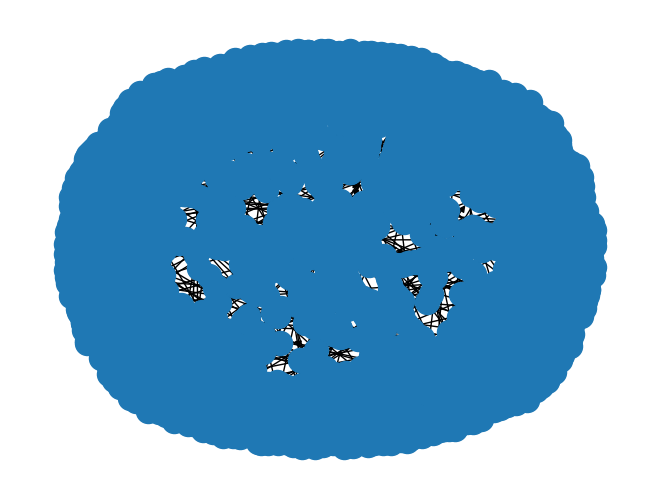

In [3]:
illicit_ids = df.loc[(df['class'] == 'illicit'), 'id']
illicit_ids = df_edgelist.loc[df_edgelist['txId1'].isin(illicit_ids)]

g = nx.from_pandas_edgelist(illicit_ids, source = 'txId1', target = 'txId2', 
                                 create_using = nx.DiGraph())
pos = nx.spring_layout(g)
nx.draw(g, with_labels=False, pos=pos)

In [4]:
nodelist = list(g.nodes)
node_df = pd.DataFrame(index=nodelist)

pos = nx.kamada_kawai_layout(g)

xs = []
ys = []
for node in nodelist:
    xs.append(pos[node][0])
    ys.append(pos[node][1])
xs = np.array(xs)
ys = np.array(ys)

node_df["x"] = xs
node_df["y"] = ys

adj = nx.to_numpy_array(g, nodelist=nodelist)
n = adj.shape[0]

node_df["degree"] = adj.sum(axis=0)

In [6]:
# random bernoullis
rng = np.random.default_rng(888)
partition = rng.binomial(1, 0.5, size=n)

partition

array([0, 0, 0, ..., 1, 0, 0])

In [7]:
def modularity_from_adjacency(sym_adj, partition, resolution=1):
    if isinstance(partition, dict):
        partition_labels = np.vectorize(partition.__getitem__)(
            np.arange(sym_adj.shape[0])
        )
    else:
        partition_labels = partition
    partition_labels = np.array(partition_labels)
    in_comm_mask = partition_labels[:, None] == partition_labels[None, :]
    degrees = np.squeeze(np.asarray(sym_adj.sum(axis=0)))
    degree_prod_mat = np.outer(degrees, degrees) / sym_adj.sum()
    mod_mat = sym_adj - resolution * degree_prod_mat
    return mod_mat[in_comm_mask].sum() / sym_adj.sum()


mod_score = modularity_from_adjacency(adj, partition)
mod_score

-0.008559932507547536

(<Figure size 1500x700 with 4 Axes>, <AxesSubplot: >)

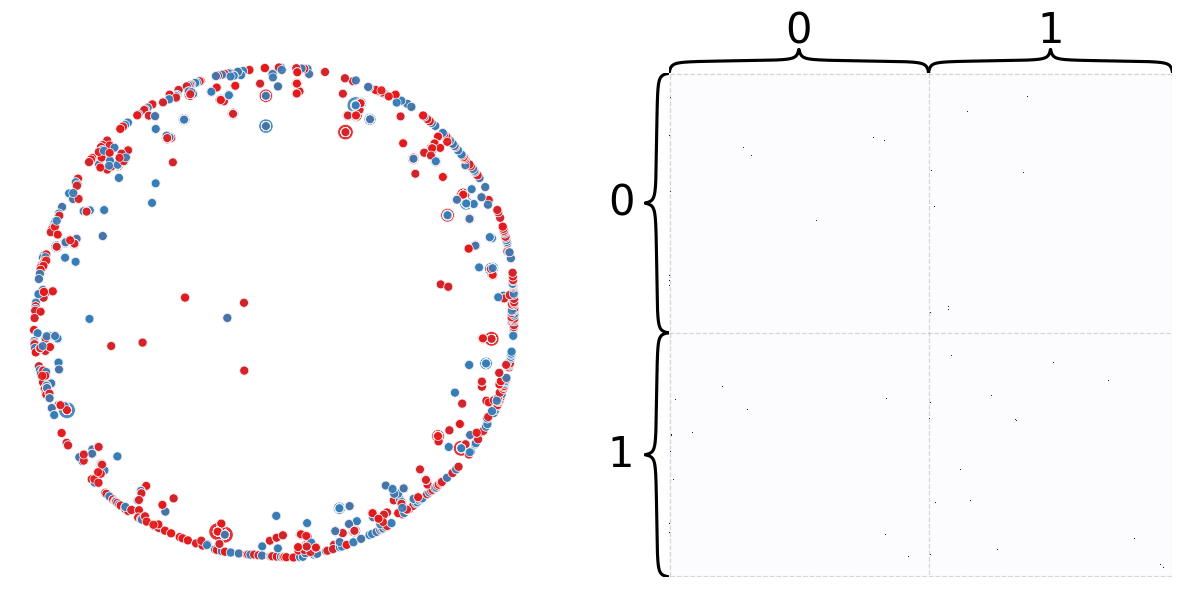

In [8]:
from graspologic.plot import networkplot, heatmap

node_df["random_partition"] = partition

def plot_network_partition(adj, node_data, partition_key):
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))

    networkplot(
        adj,
        x="x",
        y="y",
        node_data=node_df.reset_index(),
        node_alpha=0.9,
        edge_alpha=0.7,
        edge_linewidth=0.4,
        node_hue=partition_key,
        node_size="degree",
        edge_hue="source",
        ax=axs[0],
    )
    _ = axs[0].axis("off")

    _ = heatmap(
        adj,
        inner_hier_labels=node_data[partition_key],
        ax=axs[1],
        cbar=False,
        cmap="Purples",
        vmin=0,
        center=None,
        sort_nodes=True,
    )

    return fig, axs[0]

plot_network_partition(adj, node_df, 'random_partition')